In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import mpl_finance
from matplotlib import ticker
import matplotlib.dates as mdates
import os

import warnings
warnings.filterwarnings('ignore')

from utility.indicator import Indicator
from utility.draw_chart import PlotChart
from utility.general import *
from database.models import KabuDatabase
DB = KabuDatabase()
IND = Indicator()
PC = PlotChart()

'''
ind  code_list
0    tenbagger20190525
1    tenbagger20190706
2         shodo2019Jun
3         shodo2019Aug
4         shodo2019Sep
5             all_code
6         shodo2019Oct
7    tenbagger20191005
'''
ind = 7
code_list = DB.get_dataframe('mylist').loc[ind,'mylist']
# code_list = 'shodo2019Nov'
code_name = DB.get_dataframe(code_list).iloc[:,1:3]
save_directory_chart = 'results/' + code_list + '_daily_chart/'
save_directory_review = 'results/' + code_list + '_review/'
check_directory(save_directory_chart)
check_directory(save_directory_review)

In [2]:
def setting_kessan():
    _settei = input('select the number\n1: from_kijun\n2: before_after')
    if _settei == '1':
        _kessan_settei = 'from_kijun'
        _kijun_flg = True
        _kijun_date = input('基準日入力 例)2019-07-05') #基準日を設定する場合は基準日を設定する
    elif _settei == '2':
        _kessan_settei = 'before_after'
        _kijun_flg = False
        _kijun_date = None
    return _kessan_settei, _kijun_flg, _kijun_date

def setting_plot():
    _settei = input('select the number\n1: candle_only\n2: candle_and_onchart\n3: candle_with_dekidaka\n4: candle_and_onchart_with_dekidaka')
    if _settei == '1':
        _plot_settei = 'candle_only' #ローソク足のみ
    elif _settei == '2':
        _plot_settei = 'candle_and_onchart' #ローソク足とオンチャート
    elif _settei == '3':
        _plot_settei = 'candle_with_dekidaka' #ローソク足と出来高
    elif _settei == '4':
        _plot_settei = 'candle_and_onchart_with_dekidaka' #ローソク足とオンチャートと出来高
    return _plot_settei 

#描画前に日付がNANのデータを削除(INDに通すとNANが発生)
def clean_df(_df):
    _df = _df.dropna(subset = ['date'], axis = 0)
    _df['date'] = [datetime.datetime.strptime(i,'%Y-%m-%d') for i in _df['date']]
    _df = _df.set_index('date')
    _df = _df.drop('id', axis = 1)
    _df = _df[_df.index==_df.index]
    return _df

if __name__ == '__main__':

select the number
1: from_kijun
2: before_after 1
基準日入力 例)2019-07-05 2019-11-15
本日の日付入力 例)2019-11-05 2019-12-20
select the number
1: candle_only
2: candle_and_onchart
3: candle_with_dekidaka
4: candle_and_onchart_with_dekidaka 2


対象期間: 60
対象データ: tenbagger20191005
描画設定: candle_and_onchart
決算設定: from_kijun
基準日: 2019-11-15


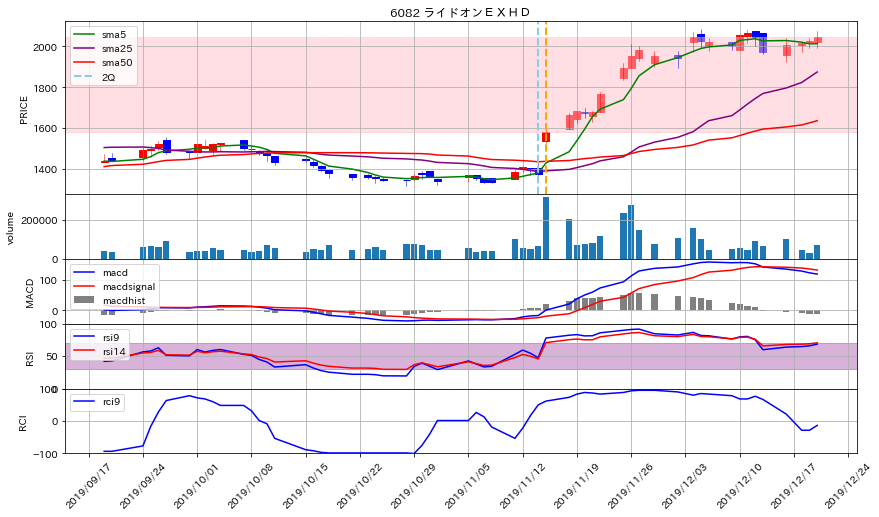

CODE1449 is no data


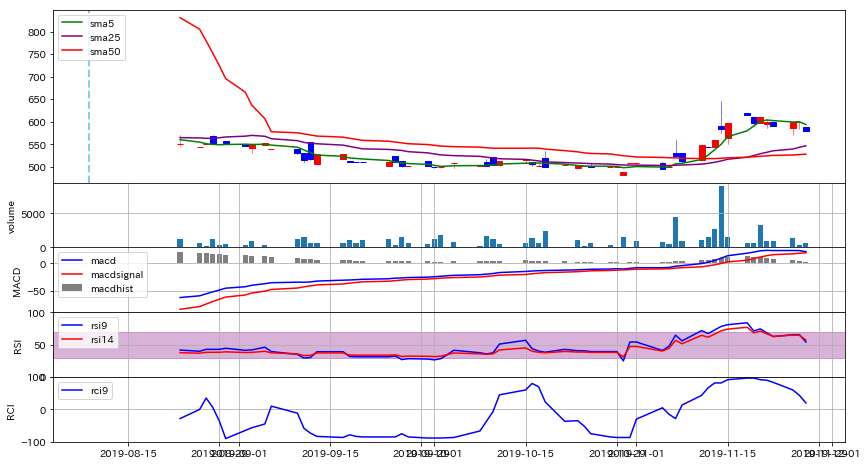

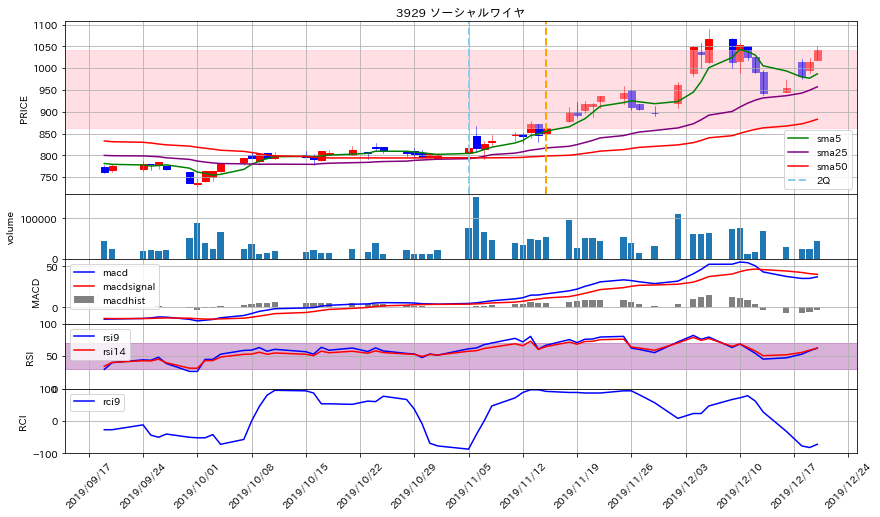

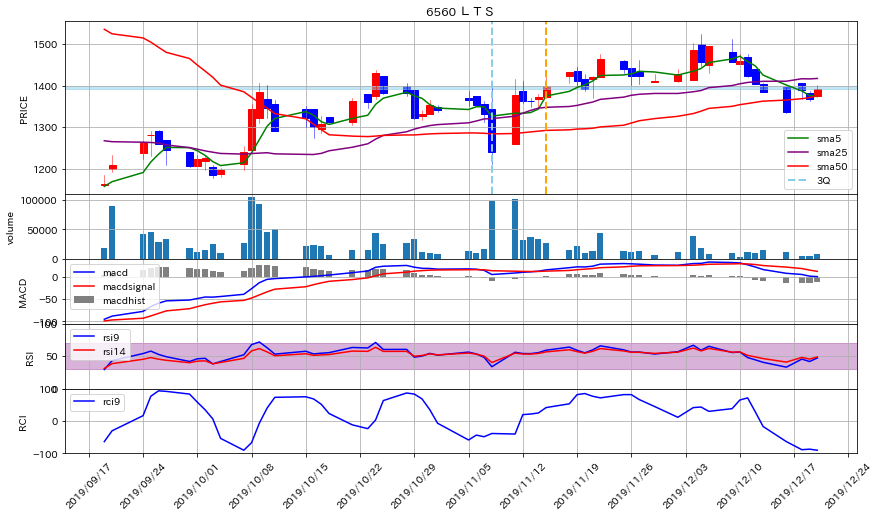

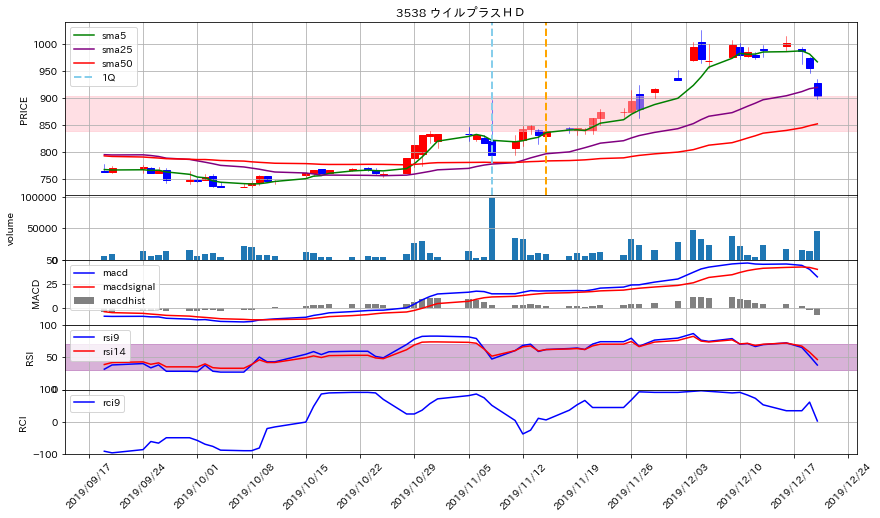

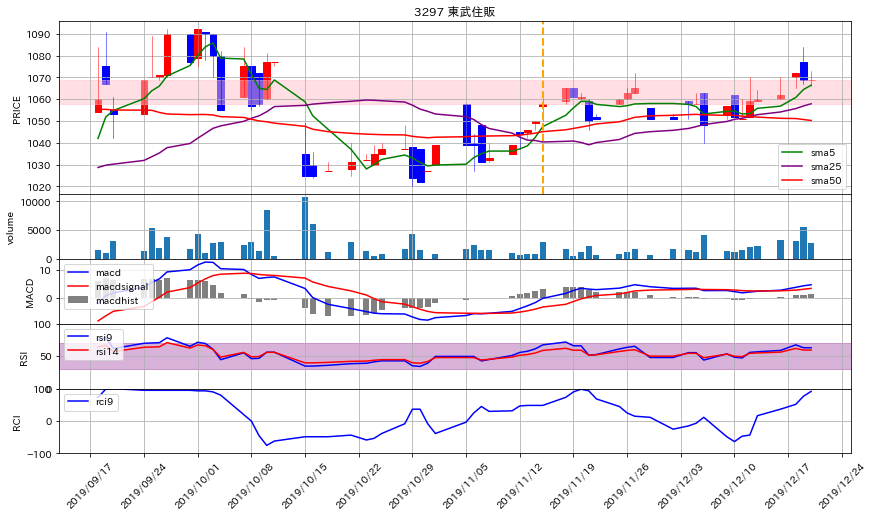

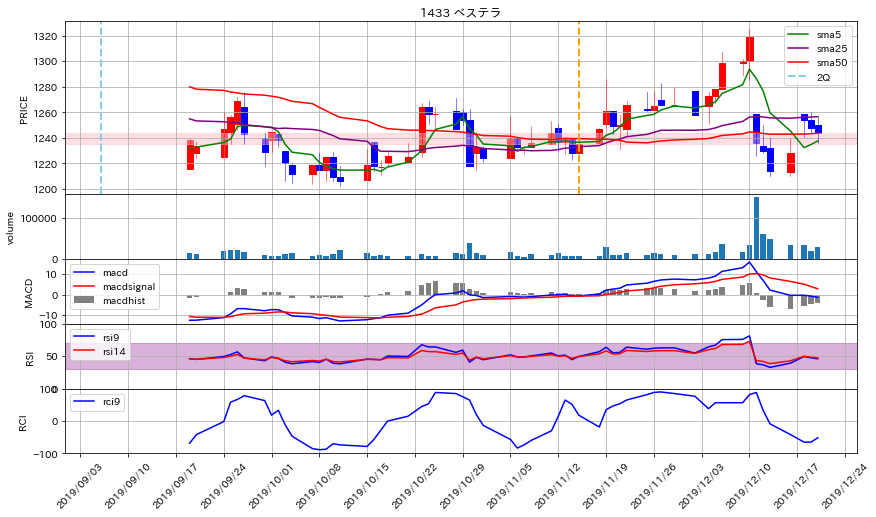

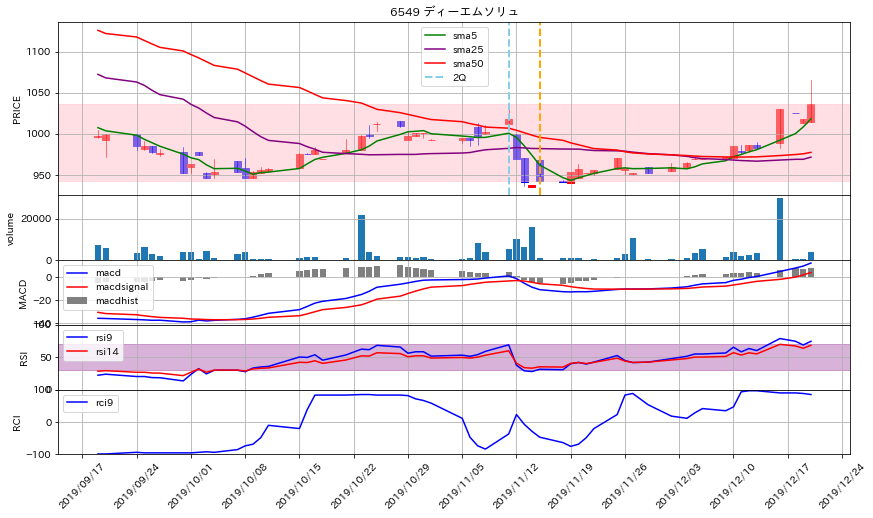

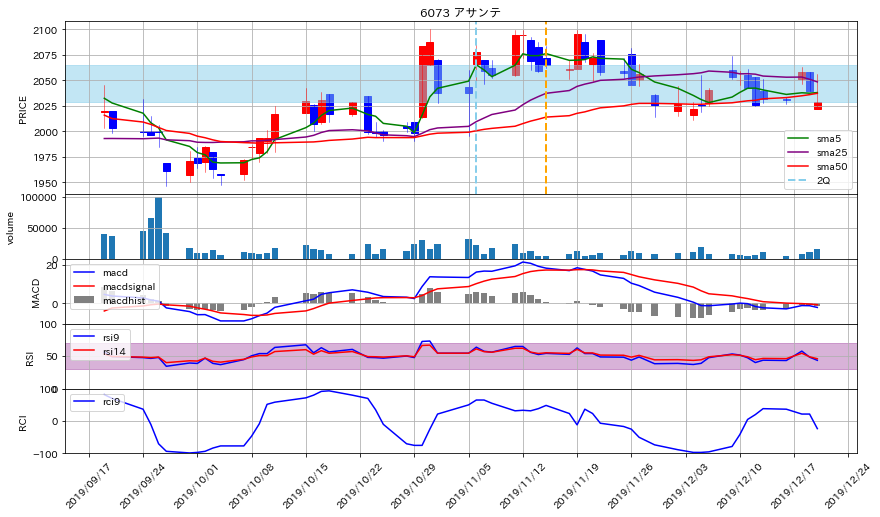

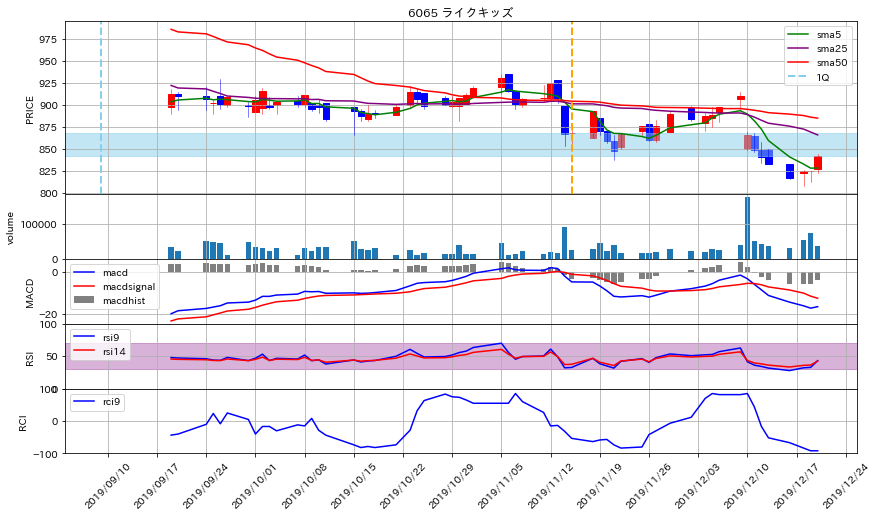

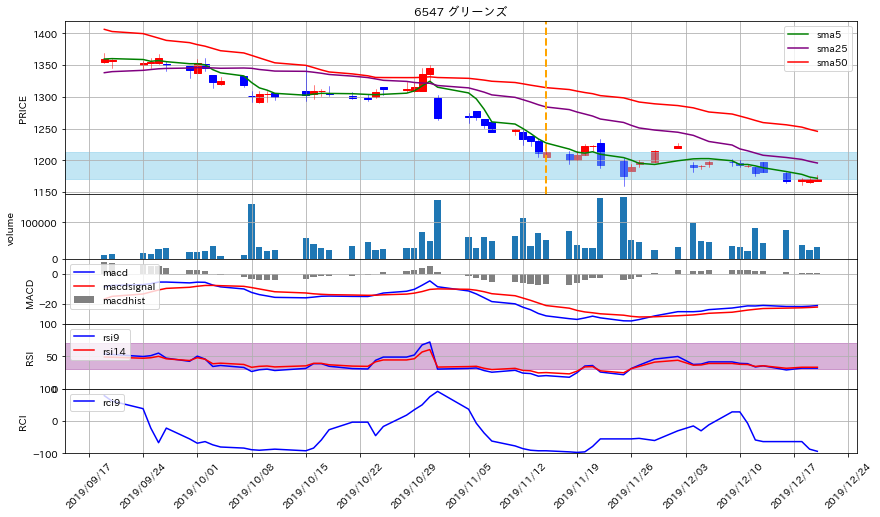

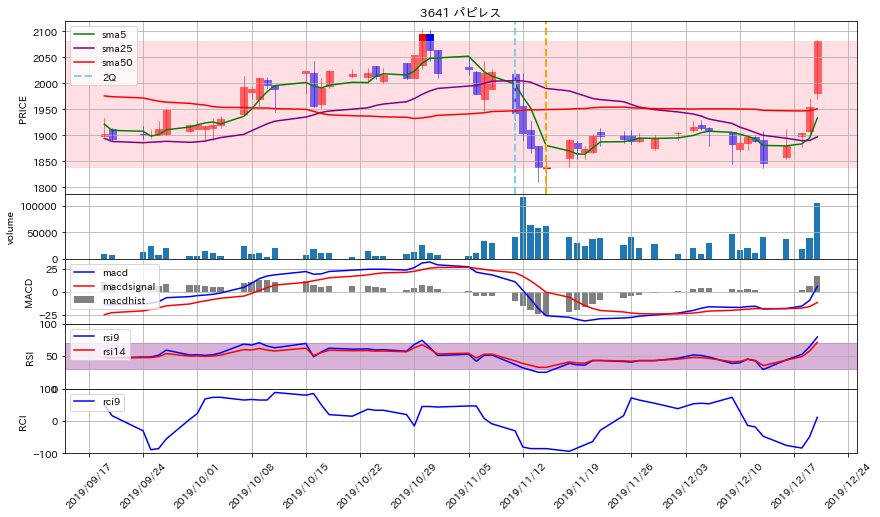

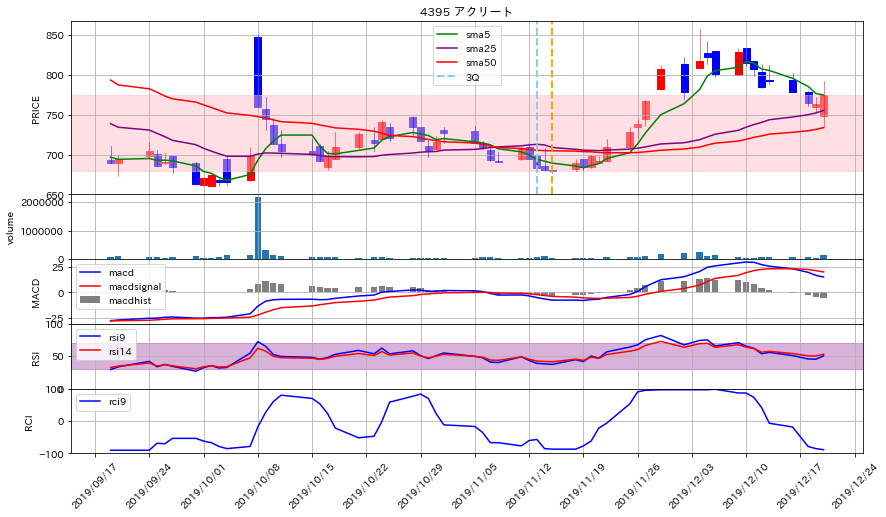

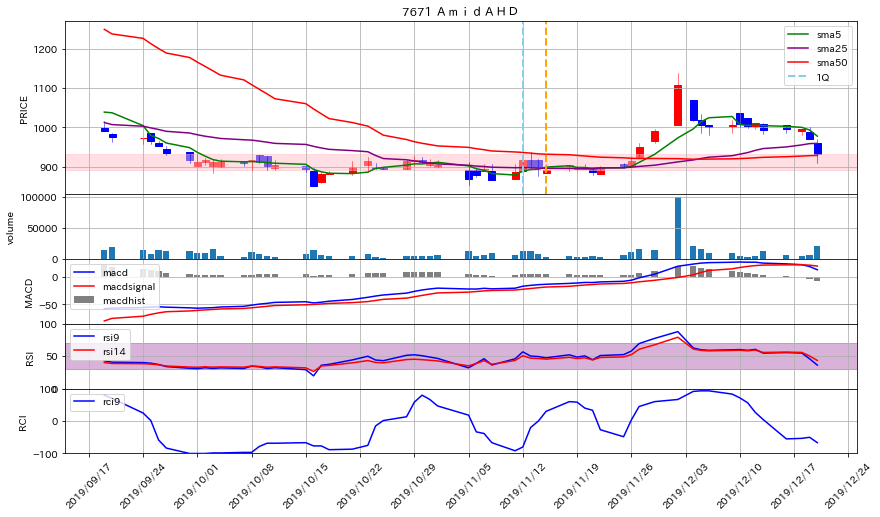

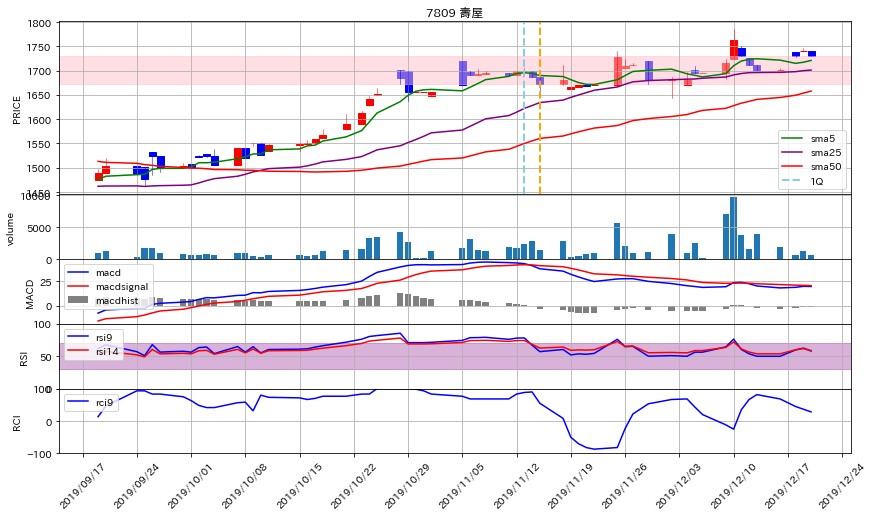

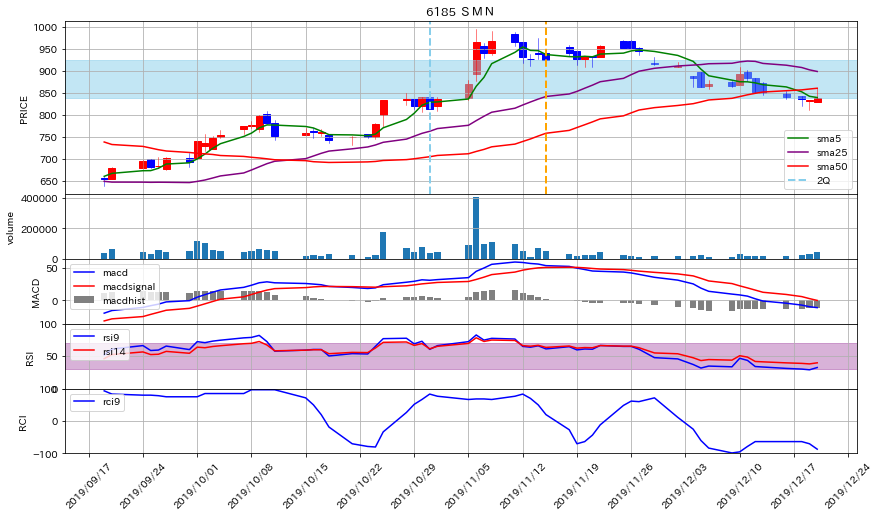

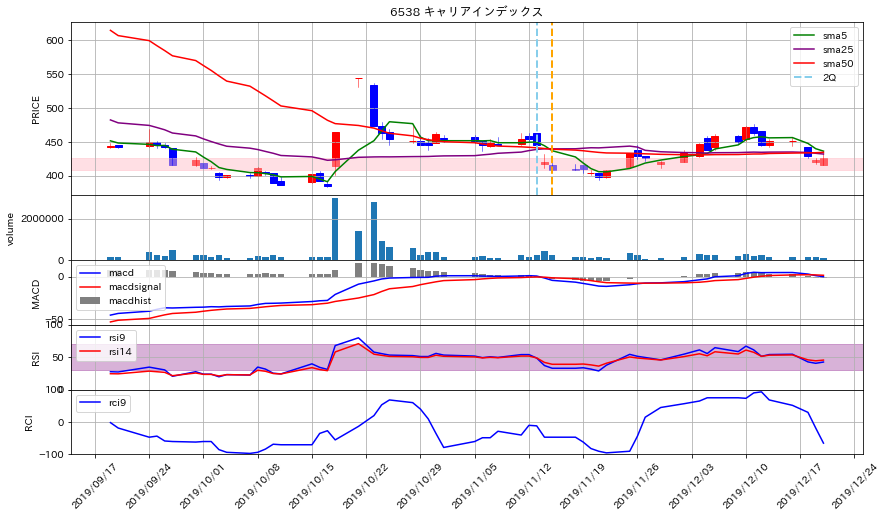

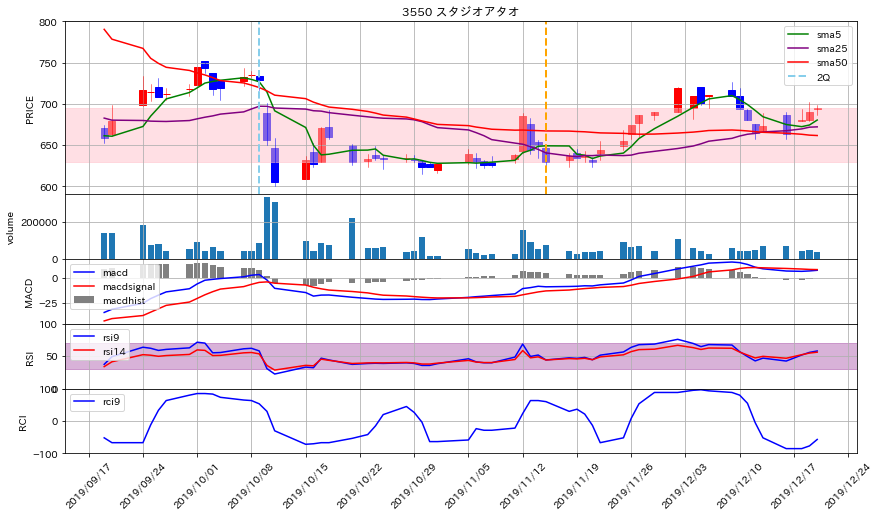

In [3]:
#----------- 設定情報 -----------
LOOKBACK = 60 #対象期間設定
kessan_settei, kijun_flg, kijun_date = setting_kessan() #基準日設定
current_date = datetime.datetime.strptime(input('本日の日付入力 例)2019-11-05'),'%Y-%m-%d')
plot_settei = setting_plot() #描画設定

#----------- 設定情報出力 -----------
print('対象期間:', LOOKBACK)
print('対象データ:', code_list)
print('描画設定:', plot_settei)
print('決算設定:', kessan_settei)
if kijun_flg:
    print('基準日:', kijun_date)

#----------- 株価描画と保存 -----------
data = []
for ind, row in code_name.iterrows():
# for i in range(1):
#     code, name = 2424, 'ブラス'
    code, name = row[0], row[1]
    try:
        df = DB.get_dataframe('CODE'+ str(code))                
        df = IND.ohlc_with_indicator(df)
        minimum, maximum, dekidaka = IND.kakakutai_dekidaka(df)
        df = clean_df(df) #描画前に日付がNANのデータを削除

        fig = plt.figure(figsize=(11,6))        
        if plot_settei == 'candle_only': #ローソク足のみ
            fig, ax = PC.simple_candlechart(fig, df.iloc[-LOOKBACK:,:])
        elif plot_settei == 'candle_and_onchart': #ローソク足とオンチャート
            fig, ax = PC.candlechart_onchart_indicator(fig, df.iloc[-LOOKBACK:,:],['sma'])
        elif plot_settei == 'candle_with_dekidaka': #ローソク足と出来高
            fig, ax, ax_d = PC.candlechart_with_dekidaka(df.iloc[-LOOKBACK:,:], minimum, maximum, dekidaka)
        elif plot_settei == 'candle_and_onchart_with_dekidaka': #ローソク足とオンチャートと出来高
            fig, ax, ax_d = PC.candlechart_onchart_indicator_with_dekidaka( \
                            fig, df.iloc[-LOOKBACK:,:], minimum, maximum, dekidaka, ['sma','bb']) 

        fig, ax, ax0, ax1, ax2, ax3 = PC.oscillator(fig, ax, df.iloc[-LOOKBACK:,:]) #オシレータ

        #optional_plot
        if code_list.find('shodo') != -1: #初動の時
            fig, ax, shodo_date, shodo_price, current_price = PC.optional_shodo(fig, ax, df.iloc[-LOOKBACK:,:], code)
            data.append([code,name, shodo_date, shodo_price,current_price])
        elif code_list.find('tenbagger') != -1: #10倍株の時
            if kessan_settei == 'from_kijun':
                fig, ax, kijun_price, current_price = \
                    PC.optional_kessan(fig, ax, df.iloc[-LOOKBACK:,:], code, kijun_flg, kijun_date, current_date)
                data.append([code, name, kijun_price, current_price])
            elif kessan_settei == 'before_after':
                fig, ax, kessan_before_price, kessan_after_price, kessan_date, kessan_term =\
                    PC.optional_kessan_before_after(fig, ax, df.iloc[-LOOKBACK:,:], code, name)
                data.append([code, name, kessan_before_price, kessan_after_price, kessan_date, kessan_term])

        ax.grid()
        ax.set_ylabel('PRICE')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
        ax.set_title('{} {}'.format(code, name))
        plt.xticks(rotation = 45)

        #図の保存
        save_directory_chart1 = save_directory_chart +'/{}day_chart'.format(LOOKBACK)
        check_directory(save_directory_chart1)
        save_path = save_directory_chart1 + '/{}-{}.png'.format(code,name)
        plt.savefig(save_path, bbox_inches="tight", pad_inches=1)
        plt.show()
    except:
        print('CODE'+ str(code) + ' is no data')

In [5]:
#----------- review結果の出力 -----------
if code_list.find('tenbagger') != -1: #10倍株の時
    if kessan_settei == 'before_after':
        df_data = pd.DataFrame(data, columns = ('コード', '銘柄', '決算日終値', '決算翌日終値','発表日','種別'))
        df_data['値上率'] = np.round((df_data['決算翌日終値'] - df_data['決算日終値'])/df_data['決算日終値']*100,2)
    elif kessan_settei == 'from_kijun':
        df_data = pd.DataFrame(data, columns = ('コード', '銘柄', '検索日終値', '現在値'))
        df_data['値上率'] = np.round((df_data['現在値'] - df_data['検索日終値'])/df_data['検索日終値']*100,2)

    df_data = df_data.sort_values('コード').reset_index(drop = True)
    df_data = df_data.set_index('コード',drop = True)
    df_data.to_csv(save_directory_review + '/review_' + kessan_settei + '.csv',encoding = 'utf-8-sig')

elif code_list.find('shodo') != -1: #初動の時
    df_data = pd.DataFrame(data, columns = ('コード', '銘柄', 'ランクイン日','ランクイン日終値', '現在値'))
    df_data['値上率'] = np.round((df_data['現在値'] - df_data['ランクイン日終値'])/df_data['ランクイン日終値']*100,2)

    df_data = df_data.sort_values('コード').reset_index(drop = True)
    df_data = df_data.set_index('コード',drop = True)
    df_data.to_csv(save_directory_review + '/review.csv',encoding = 'utf-8-sig')